# Seal Stranding Data Analysis

Max Ignatyev

MACS 401

## Objective:
- Visualize harbor seal stranding data from Washington State
- Recognize how data can provide useful metrics and or visuals

### Importing libraries to be used in project

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn
import shapely


### Reading our modified data file from NOAA Fisheries

Database file obtained by query through NOAA Fisheries, trimmed in SQL for relevant fields, then processed using pandas to create "sealDataTime.csv" file. 

Datetime conversion was done in a different python env:
![alt text](DataFiles/dateTime.png)

#### We then import our data into our notebook

In [2]:
sealData = pd.read_csv("DataFiles/sealDataTime.csv")

#### And convert our Lat/Lon values into floats

In [3]:
print(sealData.dtypes)

#dropping problematic data from the dataframe, need to perform this once only so using a counter
run = 0

if run == 0:
    sealData.drop(83,axis=0,inplace=True)
    print(sealData["Longitude"][80:85])
    run+=1

#Converting Lon and Lat to floats
sealData["Longitude"] = pd.to_numeric(sealData["Longitude"])
sealData["Latitude"] = pd.to_numeric(sealData["Latitude"])

print(sealData.dtypes)


CommonName               object
Latitude                float64
Longitude                object
ObservationDate          object
ObservationCondition     object
TransfToRehab            object
DiedAtSite               object
FinddingsOfHI            object
dtype: object
80     -122.6615
81     -124.1745
82    -122.39549
84     -124.1326
85      -122.745
Name: Longitude, dtype: object
CommonName               object
Latitude                float64
Longitude               float64
ObservationDate          object
ObservationCondition     object
TransfToRehab            object
DiedAtSite               object
FinddingsOfHI            object
dtype: object


### Summarizing Data Counts

Here we get an overview of seal stranding observation states starting with a chart to visualize proportions and followed by a short python script to loop through the data and give us information on how many seals were alive or dead.

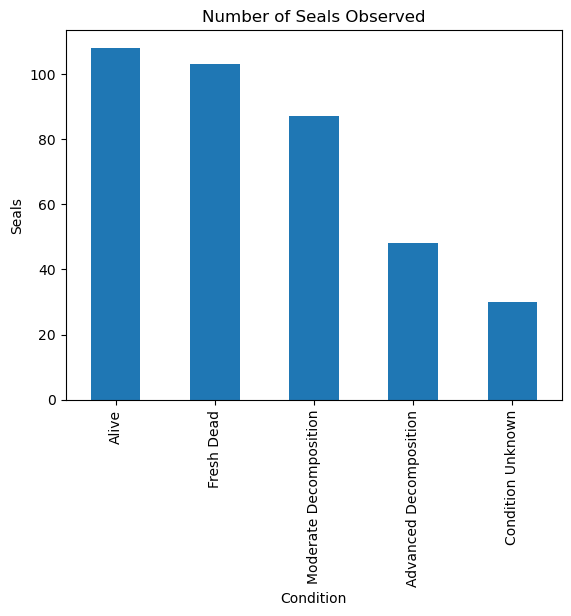

Total Number of Seals Observed Stranded in WA 2021: 384
Number of seals found alive: 108
Number of seals found dead: 246
Number of seals where condition upon finding is unknown 30
Out of 384 seals observed 28.1 % (108) were found alive


In [4]:
numSeals = sealData.groupby(['ObservationCondition']).count()


df = pd.Series(numSeals.CommonName, index = sealData['ObservationCondition'].unique())

graph1 = df.nlargest(5).plot(y = numSeals.CommonName, x = sealData['ObservationCondition'].unique(), kind = 'bar', title="Number of Seals Observed")
graph1.set_xlabel("Condition")
graph1.set_ylabel("Seals")
plt.xticks(rotation=90)

plt.show()


aliveSeals = numSeals.ObservationDate.Alive

deadSeals = 0
totSeals = 0
unknownC = 0

for seal in sealData.ObservationCondition:
    totSeals +=1
    if seal != "Alive" and seal != "Condition Unknown":
        deadSeals+=1
    elif seal == "Condition Unknown":
        unknownC +=1
        


print("Total Number of Seals Observed Stranded in WA 2021: {}".format(totSeals))
print("Number of seals found alive: {}".format(aliveSeals))
print("Number of seals found dead: {}".format(deadSeals))
print("Number of seals where condition upon finding is unknown {}".format(unknownC))

print("Out of {} seals observed {} % ({}) were found alive".format(totSeals, round(aliveSeals/totSeals * 100, 1), aliveSeals))

### Creating geopoints from latitude and longitude

In [5]:
gdf = geopandas.GeoDataFrame(
    sealData, geometry=geopandas.points_from_xy(sealData.Longitude, sealData.Latitude))

print(gdf.head())

     CommonName  Latitude   Longitude ObservationDate ObservationCondition  \
0  Seal, harbor  47.57770 -122.525400      2021-01-03           Fresh Dead   
1  Seal, harbor  47.57980 -122.525900      2021-01-06    Condition Unknown   
2  Seal, harbor  47.38130 -122.635600      2021-01-07           Fresh Dead   
3  Seal, harbor  47.52645 -122.395383      2021-01-13           Fresh Dead   
4  Seal, harbor  47.86770 -122.514700      2021-01-16                Alive   

  TransfToRehab DiedAtSite FinddingsOfHI                     geometry  
0             N          N           CBD  POINT (-122.52540 47.57770)  
1             N          N           CBD  POINT (-122.52590 47.57980)  
2             N          N             N  POINT (-122.63560 47.38130)  
3           NaN        NaN           CBD  POINT (-122.39538 47.52645)  
4             N          N           CBD  POINT (-122.51470 47.86770)  


/Users/maxignatyev/anaconda3/envs/e4_jupyter_notebook/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


### Geopandas dataframe experimentation

I wanted to see what kind of quick visuals I could mock up with the data now that I made a geopandas dataframe.

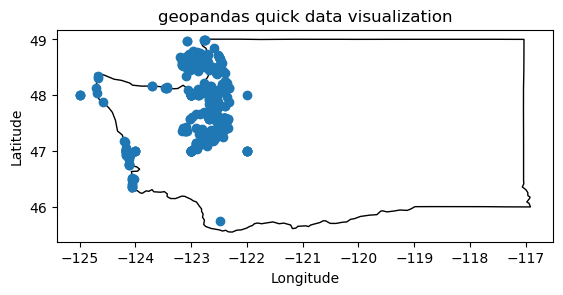

In [13]:
states = geopandas.read_file('anaconda3/data/usa-states-census-2014.shp')
type(states)

states[states['NAME'] == 'Washington']



#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

axis = states[states['NAME'] == 'Washington'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax = axis)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("geopandas quick data visualization")

plt.show()




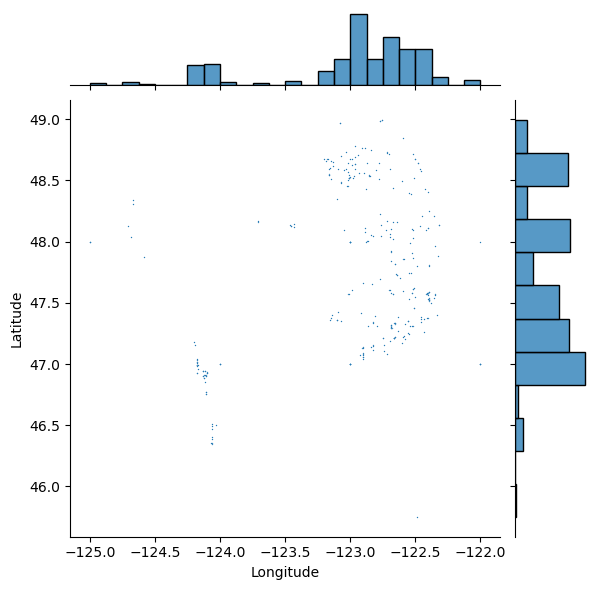

In [7]:
seaborn.jointplot(x="Longitude", y="Latitude", data=gdf, s=1);

In [8]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)


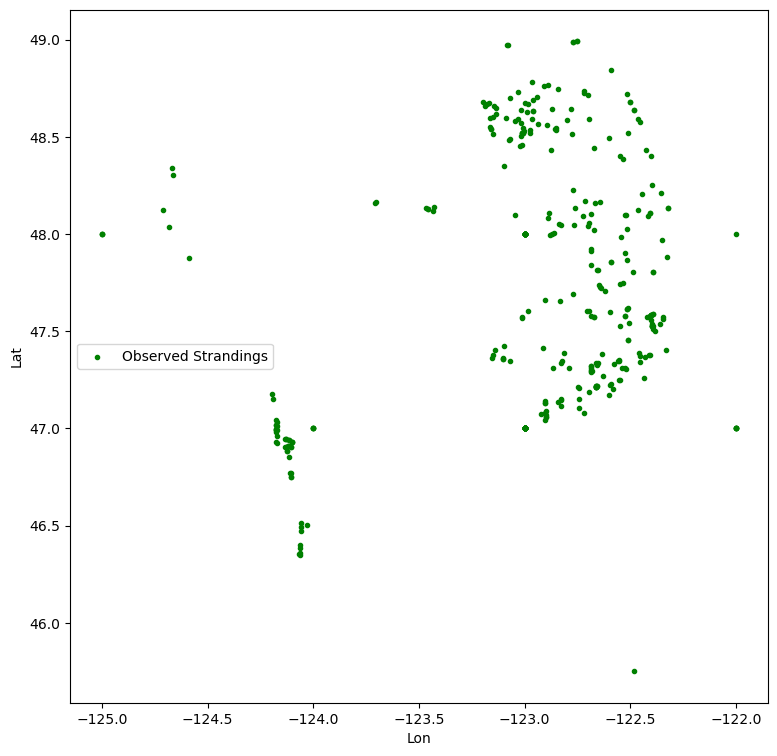

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    x="Longitude", y="Latitude", data=gdf,
    color="green",
    marker=".",
    label="Observed Strandings"
)

ax.legend(ncol=1, loc="center left")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.show()


### Creating shapely geometry from our dataset

In [10]:
geomList = [shapely.geometry.Point(lon,lat) for lon,lat in zip(sealData["Longitude"] ,sealData["Latitude"])]

## Visualizing Data using qGIS

qGIS is an open source GIS software that I used to map the coordinate points and to create a timeseries visual.
Similar work can be accomplished through basemap package for python or one of the GIS packages available to use in the notebook, however I was limited on packages I could use since this notebook was run in a virtual python environment.

All *P. vitulina* strandings visualized using OpenStreetMaps as basemap: 
![alt text](DataFiles/pvstrandings.png)

*P. vitulina* strandings visualized using time series: 
![alt text](DataFiles/stranding.gif)

## Questions in dataset application

### What questions can visual analysis of stranding data answer?

- Where do most strandings happen?
- Are there correlations between events such as pupping season?
- How does stranding data compare year by year?
- What jurisdictions have the most cases?

#### GIS software allows some data analysis such as point counting within a polygon.
I found this usefull for mapping stranding network jurisdictions and seeing how many seal strandings
a jurisdiction would have.

![alt text](DataFiles/zones.png)

In this example, Whatcom Stranding Network is shown in yellow and WDFW Stranding Network is shown in Blue.
Counts for this returned 16 cases in Yellow, 79 in Blue area.

# Conclusions

- Due to the categorical nature of stranding data, little can be done in terms of mathematical analysis
- Coordinate visualization seems to be on of the most useful tools in analyzing the stranding data and can help answer geospacial questions
- **In the future** more work can be done in comparing location data over a longer period of time to determine trends in stranding data